In [69]:
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt

In [70]:
# get the features detected in ms1 and de-duped
ms1_dedup_features_df = pd.read_pickle('/Users/darylwilding-mcbride/Downloads/rt-3000-3060-nddms1.pkl')

In [71]:
ms1_dedup_features_df.columns

Index(['candidate_phr_error', 'charge', 'envelope', 'intensity',
       'intensity_full_rt_extent', 'mono_adjusted', 'monoisotopic_mz',
       'ms2_frames', 'ms2_scan_ranges', 'original_phr', 'original_phr_error',
       'precursor_id', 'rt_apex', 'rt_curve_fit', 'rt_lower', 'rt_upper',
       'scan_apex', 'scan_curve_fit', 'scan_lower', 'scan_upper', 'duplicates',
       'feature_id'],
      dtype='object')

In [72]:
MZ_TOLERANCE_PPM = 40
RT_APEX_TOLERANCE = 2
SCAN_APEX_TOLERANCE = 20
MZ_TOLERANCE_PERCENT = MZ_TOLERANCE_PPM * 10**-4

In [73]:
features_belonging_together_l = []

scratch_df = ms1_dedup_features_df.copy() # take a copy because we're going to delete stuff
scratch_df.sort_values(by=['intensity'], ascending=False, inplace=True)
group_id = 1

while len(scratch_df) > 0:
    scratch_df.reset_index(drop=True, inplace=True)
    # take the first row
    row = scratch_df.iloc[0]
    mz = row.monoisotopic_mz
    scan = row.scan_apex
    rt = row.rt_apex

    # calculate the matching bounds
    mz_ppm_tolerance = mz * MZ_TOLERANCE_PERCENT / 100
    mz_lower = mz - mz_ppm_tolerance
    mz_upper = mz + mz_ppm_tolerance
    scan_lower = scan - SCAN_APEX_TOLERANCE
    scan_upper = scan + SCAN_APEX_TOLERANCE
    rt_lower = rt - RT_APEX_TOLERANCE
    rt_upper = rt + RT_APEX_TOLERANCE

    # find the matches within these tolerances
    cond_1 = (scratch_df.monoisotopic_mz >= mz_lower) & (scratch_df.monoisotopic_mz <= mz_upper) & (scratch_df.scan_apex >= scan_lower) & (scratch_df.scan_apex <= scan_upper) & (scratch_df.rt_apex >= rt_lower) & (scratch_df.rt_apex <= rt_upper)
    matching_rows = scratch_df.loc[cond_1, :].copy()
    matching_rows['group_id'] = group_id
    group_id += 1
    # add all the features belonging together to the list with the same group ID
    features_belonging_together_l.append(matching_rows)
    # drop the duplicates
    scratch_df.drop(matching_rows.index, inplace=True)

# join the list of dataframes into a single dataframe
features_belonging_together_df = pd.concat(features_belonging_together_l, sort=True)


In [74]:
features_belonging_together_df.head(2)

,candidate_phr_error,charge,duplicates,envelope,feature_id,group_id,intensity,intensity_full_rt_extent,mono_adjusted,monoisotopic_mz,...,original_phr_error,precursor_id,rt_apex,rt_curve_fit,rt_lower,rt_upper,scan_apex,scan_curve_fit,scan_lower,scan_upper
0,NaN,3,10,"((591.6430, 2853157.00), (591.9775, 2668880.00...",1,1,7666139.0,4364451,False,591.641799,...,-0.022660,93756,3050.48,True,3039.44,3061.51,613.23,True,573.25,653.21
0,NaN,3,9,"((529.5872, 1940798.00), (529.9214, 1715981.00...",2,2,5037820.0,3316192,False,529.585476,...,0.033541,92233,3007.03,True,2994.55,3019.51,689.51,True,660.54,718.49


In [75]:
group_count = []
for name,group_df in features_belonging_together_df.groupby('group_id'):
    group_count.append((name, len(group_df)))

In [76]:
group_count_df = pd.DataFrame(group_count, columns=['group_id','feature_count'])

Show the number of features in a group

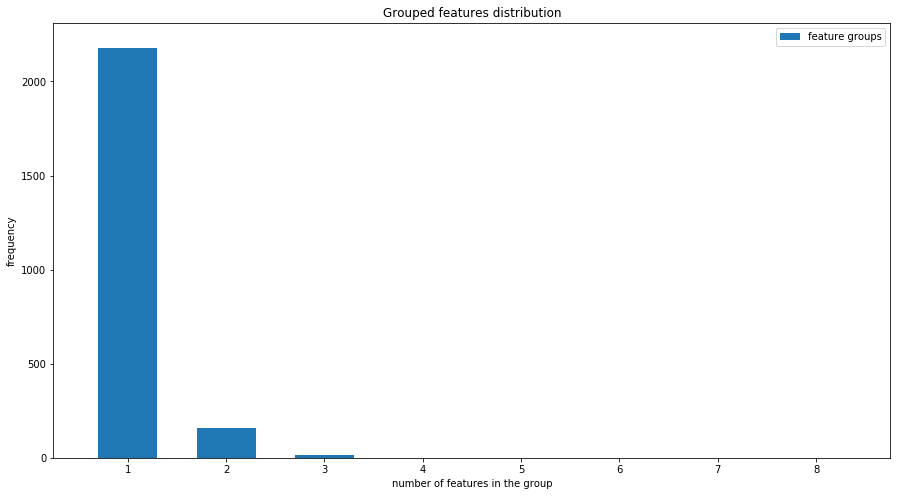

In [79]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('Grouped features distribution')

h_bins = 10
plt.hist(group_count_df.feature_count, bins=np.arange(start=1, stop=10)-0.5, rwidth=0.6, label='feature groups')
plt.legend(loc='best')
plt.xlabel('number of features in the group')
plt.ylabel('frequency')

# plt.xlim([25,150])
# plt.ylim([0,25])

plt.show()

In [ ]:
Find the number of identifications for the features with more than one in a 